In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sliced.datasets import make_cubic
from sliced import SlicedInverseRegression
from sliced import SlicedAverageVarianceEstimation
from sliced import datasets
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
import torch.utils.data as Data
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import math

/home/luhung3080/miniconda3/envs/chou/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data=pd.read_csv('/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/data_final.csv')

# Generate X Y

In [3]:
x1Restruct_Fun=np.zeros([604,3408])
x2Restruct_Fun=np.zeros([604,5112])

#x1 (0th~1703th column as x)
for i in range (0,604):
    for j in range (0,71):
        a=np.array(data['pm25_obs'][5112*i+72*j:5112*i+72*j+48])
        for k in range (0,48):
            x1Restruct_Fun[i][j*48+k]=a[k]

#x2 (1704th~8520th column as x)
for i in range (0,604):
    b=np.array(data['pm25_cal'][5112*i:5112*i+5112])
    for j in range(0,5112):
        x2Restruct_Fun[i][j]=b[j]
        
print(np.shape(x1Restruct_Fun))
print(np.shape(x2Restruct_Fun))

(604, 3408)
(604, 5112)


In [4]:
YRestruct_Fun=np.zeros([601,5112])
for j in range (0,71):
    for i in range(0,601):
        YRestruct_Fun[i][72*j:72*j+24]=x1Restruct_Fun[2+i][48*j:48*j+24]
        YRestruct_Fun[i][72*j+24:72*j+48]=x1Restruct_Fun[2+i+1][48*j:48*j+24]
        YRestruct_Fun[i][72*j+48:72*j+72]=x1Restruct_Fun[2+i+1][48*j+24:48*j+48]
print(np.shape(YRestruct_Fun))

(601, 5112)


In [5]:
XRestruct_Fun=np.zeros([601,8520])
for i in range (0,601):
    for j in range (0,3408):
        XRestruct_Fun[i][j]=x1Restruct_Fun[i][j]
    for j in range (3408,8520):
        XRestruct_Fun[i][j]=x2Restruct_Fun[i+2][j-3408]
print(np.shape(XRestruct_Fun))

(601, 8520)


In [6]:
Xhat=XRestruct_Fun
Yhat=YRestruct_Fun
Xhat_train = np.zeros([540,8520])
Yhat_train = np.zeros([540,5112])
Xhat_val = np.zeros([61,8520])
Yhat_val = np.zeros([61,5112])
Xhat_test = np.zeros([61,8520])
Yhat_test = np.zeros([61,5112])

for i in range (0,540):
    for j in range (0,3408):
        Xhat_train[i][j] = Xhat[i][j]
    for j in range (0,5112):    
        Xhat_train[i][j+3408] = Xhat[i][j+3408]
        Yhat_train[i][j] = Yhat[i][j]
        
for i in range (540,601):
    for j in range (0,3408):
        Xhat_val[i-540][j] = Xhat[i][j]
    for j in range (0,5112):
        Xhat_val[i-540][j+3408] = Xhat[i][j+3408]
        Yhat_val[i-540][j] = Yhat[i][j]     
        
for i in range (540,601):
    for j in range (0,3408):
        Xhat_test[i-540][j] = Xhat[i][j]
    for j in range (0,5112):
        Xhat_test[i-540][j+3408] = Xhat[i][j+3408]
        Yhat_test[i-540][j] = Yhat[i][j]
        
print('Xhat_train')
print(np.shape(Xhat_train))
print('Yhat_train')
print(np.shape(Yhat_train))
print('Xhat_val')
print(np.shape(Xhat_val))
print('Yhat_val')
print(np.shape(Yhat_val))
print('Xhat_test')
print(np.shape(Xhat_test))
print('Yhat_test')
print(np.shape(Yhat_test))

Xhat_train
(540, 8520)
Yhat_train
(540, 5112)
Xhat_val
(61, 8520)
Yhat_val
(61, 5112)
Xhat_test
(61, 8520)
Yhat_test
(61, 5112)


## Sparse and Expend data

In [7]:
X1hat_train = np.zeros([540,3408])
X2hat_train = np.zeros([540,5112])
X1hat_test = np.zeros([61,3408])
X2hat_test = np.zeros([61,5112])
for i in range (0,540):
    for j in range (0,3408):
        X1hat_train[i][j] = Xhat[i][j]
    for j in range (3408,8520):
        X2hat_train[i][j-3408] = Xhat[i][j]
for i in range (540,601):
    for j in range (0,3408):
        X1hat_test[i-540][j] = Xhat[i][j]    
    for j in range (3408,8520):
        X2hat_test[i-540][j-3408] = Xhat[i][j]
print('X1hat_train')
#print(X1hat_train)
print(np.shape(X1hat_train))
print('X2hat_train')
#print(X2hat_train)
print(np.shape(X2hat_train))
print('X1hat_test')
#print(X1hat_test)
print(np.shape(X1hat_test))
print('X2hat_test')
#print(X2hat_test)
print(np.shape(X2hat_test))

X1hat_train
(540, 3408)
X2hat_train
(540, 5112)
X1hat_test
(61, 3408)
X2hat_test
(61, 5112)


In [38]:
new_x=np.zeros([540*72,8520]) #38880
new_y=np.zeros([540*72,5112]) #38880
#new_x : 0th~3408th column
for i in range (0,72):
    for j in range (0,540):
        for k in range (0,3408):
            new_x[540*i+j][k]=X1hat_train[j][k]
#new_x : 3408th~8519th column
for i in range (0,72):
    for j in range (0,540):
        for k in range (0+i,5040+1+i,72): #5040=5112-72
            new_x[540*i+j][3408+k]=X2hat_train[j][k]
#new_y
for i in range (0,72):
    for j in range (0,540):
        for k in range (0,5112):
            new_y[540*i+j][k]=YRestruct_Fun[j][k]         

print(np.shape(new_x))
print(np.shape(new_y))

(38880, 8520)
(38880, 5112)


In [39]:
xf = np.zeros([61,8520])
for i in range (0,61):
    for j in range(0,8520):
        xf[i][j] = XRestruct_Fun[i+540][j]

x1 = np.zeros([61,3408])
x2 = np.zeros([61,5112])
for i in range (0,61):
    for j in range (0,3408):
        x1[i][j] = xf[i][j]
    for j in range (3408,8520):
        x2[i][j-3408] = xf[i][j]

new_exx=np.zeros([61*72,8520]) 
#new_x : 0th~3408th column
for i in range (0,72):
    for j in range (0,61):
        for k in range (0,3408):
            new_exx[61*i+j][k]=x1[j][k]
#new_x : 3408th~8519th column
for i in range (0,72):
    for j in range (0,61):
        for k in range (0+i,5040+1+i,72):  #5040=5112-72
            new_exx[61*i+j][3408+k]=x2[j][k]

print(np.shape(new_exx))
# print(np.linalg.matrix_rank(new_x))

(4392, 8520)


In [40]:
yf = np.zeros([61,5112])
for i in range (0,61):
    for j in range(0,5112):
        yf[i][j] = YRestruct_Fun[i+540][j]

new_eyy=np.zeros([61*72,5112]) 
for i in range (0,72):
    for j in range (0,61):
        for k in range (0,5112):
            new_eyy[61*i+j][k]=yf[j][k] 

print(np.shape(new_eyy))
# print(np.linalg.matrix_rank(new_eyy))

(4392, 5112)


# Original Data

In [41]:
error1 = mean_absolute_error(Xhat_test[:,3408:], Yhat_test)
error2 = mean_squared_error(Xhat_test[:,3408:], Yhat_test)
print('testing data MAE is ',error1)
print('testing data MAE is ',error2)

testing data MAE is  6.960797218740769
testing data MAE is  91.37389317489043


# Concurrent Model

## Gradient descent (loss = MAE)

In [67]:
x = Xhat_train
y = Yhat_train
xt = Xhat_test
yt = Yhat_test

In [68]:
def model (x,b0,b1):
    y = b0 +  torch.matmul(x , b1)
    return y

In [69]:
features = torch.from_numpy(x)
targets = torch.from_numpy(y)
x_test = torch.from_numpy(xt)
y_test = torch.from_numpy(yt)

beta0 = torch.zeros(5112 , requires_grad = True)
beta1 = torch.zeros([8520,5112], requires_grad = True)

rate = 1e-4
optimizer = optim.Adam([beta0 , beta1], lr=rate)

epo = 500
loss = nn.L1Loss()
train_error = np.zeros(epo)
test_error_MAE = np.zeros(epo)
test_error_MSE = np.zeros(epo)


for epoch in range (epo):
    yhats_train = model(features.float() , beta0 , beta1)
    train_loss = loss(targets.float() , yhats_train)
    train_error[epoch] = train_loss

    optimizer.zero_grad()
    train_loss.backward() 
    optimizer.step()    

    yhats_test = model(x_test.float(), beta0, beta1) 
    r = abs(yhats_test - y_test)
    test_error_MAE[epoch] = torch.nanmean(r)
    test_error_MSE[epoch] = torch.nanmean(r*r)

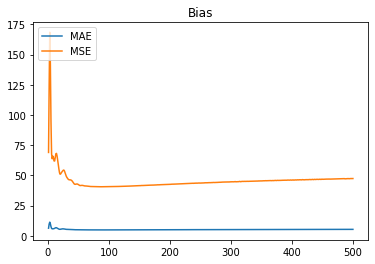

In [70]:
fig1 = plt.figure(1)
x=np.linspace(1,epo,epo)
plt.plot(x,test_error_MAE, label = 'MAE')
plt.plot(x,test_error_MSE, label ='MSE')
plt.legend(loc = 2)
plt.title('Bias')

plt.show()

In [71]:
print('testing data MAE is ', np.min(test_error_MAE))
print('testing data MAE is ', np.min(test_error_MSE))

testing data MAE is  4.820338584565142
testing data MAE is  40.51668798818331


## Gradient descent (loss = MSE)

In [72]:
x = Xhat_train
y = Yhat_train
xt = Xhat_test
yt = Yhat_test

In [73]:
def model (x,b0,b1):
    y = b0 +  torch.matmul(x , b1)
    return y

In [74]:
features = torch.from_numpy(x)
targets = torch.from_numpy(y)
x_test = torch.from_numpy(xt)
y_test = torch.from_numpy(yt)

beta0 = torch.zeros(5112 , requires_grad = True)
beta1 = torch.zeros([8520,5112], requires_grad = True)

rate = 1e-4
optimizer = optim.Adam([beta0 , beta1], lr=rate)

epo = 500
loss = nn.MSELoss()
train_error = np.zeros(epo)
test_error_MAE = np.zeros(epo)
test_error_MSE = np.zeros(epo)


for epoch in range (epo):
    yhats_train = model(features.float() , beta0 , beta1)
    train_loss = loss(targets.float() , yhats_train)
    train_error[epoch] = train_loss

    optimizer.zero_grad()
    train_loss.backward() 
    optimizer.step()    

    yhats_test = model(x_test.float(), beta0, beta1) 
    r = abs(yhats_test - y_test)
    test_error_MAE[epoch] = torch.nanmean(r)
    test_error_MSE[epoch] = torch.nanmean(r*r)

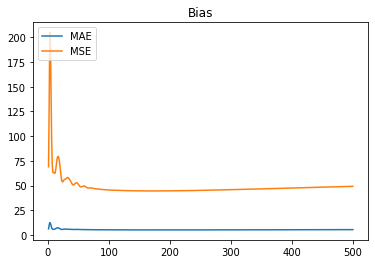

In [75]:
fig1 = plt.figure(1)
x=np.linspace(1,epo,epo)
plt.plot(x,test_error_MAE, label = 'MAE')
plt.plot(x,test_error_MSE, label ='MSE')
plt.legend(loc = 2)
plt.title('Bias')

plt.show()

In [76]:
print('testing data MAE is ', np.min(test_error_MAE))
print('testing data MAE is ', np.min(test_error_MSE))

testing data MAE is  5.1359734251055436
testing data MAE is  44.54589437358782


## Gradient descent (loss = Huber loss)

In [77]:
x = Xhat_train
y = Yhat_train
xt = Xhat_test
yt = Yhat_test

In [78]:
def model (x,b0,b1):
    y = b0 +  torch.matmul(x , b1)
    return y

In [79]:
features = torch.from_numpy(x)
targets = torch.from_numpy(y)
x_test = torch.from_numpy(xt)
y_test = torch.from_numpy(yt)

beta0 = torch.zeros(5112 , requires_grad = True)
beta1 = torch.zeros([8520,5112], requires_grad = True)

rate = 1e-4
optimizer = optim.Adam([beta0 , beta1], lr=rate)

epo = 500
loss = nn.HuberLoss()
train_error = np.zeros(epo)
test_error_MAE = np.zeros(epo)
test_error_MSE = np.zeros(epo)


for epoch in range (epo):
    yhats_train = model(features.float() , beta0 , beta1)
    train_loss = loss(targets.float() , yhats_train)
    train_error[epoch] = train_loss

    optimizer.zero_grad()
    train_loss.backward() 
    optimizer.step()    

    yhats_test = model(x_test.float(), beta0, beta1) 
    r = abs(yhats_test - y_test)
    test_error_MAE[epoch] = torch.nanmean(r)
    test_error_MSE[epoch] = torch.nanmean(r*r)

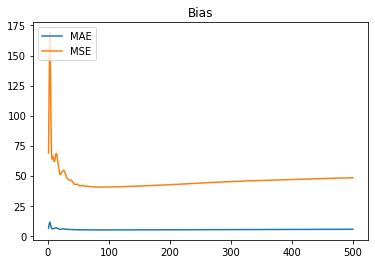

In [80]:
fig1 = plt.figure(1)
x=np.linspace(1,epo,epo)
plt.plot(x,test_error_MAE, label = 'MAE')
plt.plot(x,test_error_MSE, label ='MSE')
plt.legend(loc = 2)
plt.title('Bias')

plt.show()

In [81]:
print('testing data MAE is ', np.min(test_error_MAE))
print('testing data MAE is ', np.min(test_error_MSE))

testing data MAE is  4.817089296649324
testing data MAE is  40.46053998728874


# Mix Model

## 公式解（PCA + Linear regression）

In [42]:
x = new_x
y = new_y
xt = new_exx
yt = Yhat_test

In [43]:
xper = np.zeros(5)
xper[0] = 0.85
xper[1] = 0.9
xper[2] = 0.95
xper[3] = 0.99
xper[4] = 0.995
yper = xper
test_error_MAE = 100*np.ones(25)
test_error_MSE = 100*np.ones(25)
MAE_index=[]
MSE_index=[]

In [44]:
for z in range (0,5):
    for w in range (0,5):
        pca_x = PCA(n_components=xper[z])
        pca_x.fit(x)
        x_pca=pca_x.transform(x)
        
        pca_y = PCA(n_components=yper[w])
        pca_y.fit(y)
        y_pca=pca_y.transform(y)
        
        model = LinearRegression()
        model.fit(x_pca, y_pca)

        xt_pca = pca_x.transform(xt)
        fit_x = model.predict(xt_pca)
        fit = pca_y.inverse_transform(fit_x)
        fit95 = np.zeros([61,5112])
        for i in range (0,72):
            for j in range (0,61):
                for k in range (0,71):
                    fit95[j][72*k+i]=fit[61*i+j][72*k+i]
        mae = np.mean(abs(fit95-yt))
        mse = np.mean((fit95-yt)**2)
        test_error_MAE[z*5+w] = mae
        test_error_MSE[z*5+w] = mse
        MAE_index.append((xper[z], yper[w], mae))
        MSE_index.append((xper[z], yper[w], mse))

In [45]:
f1 = np.argmin(test_error_MAE)
f2 = np.argmin(test_error_MSE)
print('test data on x = ', 100*MAE_index[f1][0], '% Y = ', 100*MAE_index[f1][1], '% have the min MAE error :', min(test_error_MAE))
print(MAE_index[f1])
print('test data on x = ', 100*MSE_index[f2][0], '% Y = ', 100*MSE_index[f2][1], '% have the min MSE error :', min(test_error_MSE))
print(MSE_index[f2])

test data on x =  90.0 % Y =  85.0 % have the min MAE error : 5.8319428207656125
(0.9, 0.85, 5.8319428207656125)
test data on x =  90.0 % Y =  85.0 % have the min MSE error : 58.57204385984539
(0.9, 0.85, 58.57204385984539)


## Gradient descent (loss = MAE)

In [52]:
x1 = X1hat_train
x2 = X2hat_train
y = Yhat_train
xt1 = X1hat_test
xt2 = X2hat_test
yt = Yhat_test

In [53]:
def model (x1,x2,b0,b1,b2):
    y = b0 +  torch.matmul(x1,b1) + x2*b2
    return y

In [54]:
features1 = torch.from_numpy(x1)
features2 = torch.from_numpy(x2)
targets = torch.from_numpy(y)
x_test1 = torch.from_numpy(xt1)
x_test2 = torch.from_numpy(xt2)
y_test = torch.from_numpy(yt)


beta0 = torch.zeros(5112 , requires_grad = True)
beta1 = torch.zeros([3408,5112], requires_grad = True)
beta2 = torch.zeros(5112, requires_grad = True)

rate = 1e-3
optimizer = optim.Adam([beta0 , beta1 , beta2], lr=rate)

epo = 500
loss = nn.L1Loss()
train_error = np.zeros(epo)
test_error_MAE = np.zeros(epo)
test_error_MSE = np.zeros(epo)

for epoch in range (epo):
    yhats_train = model(features1.float() , features2.float(), beta0 , beta1 , beta2)
    train_loss = loss(targets.float() , yhats_train)
    train_error[epoch] = train_loss

    optimizer.zero_grad()
    train_loss.backward() 
    optimizer.step()    

    yhats_test = model(x_test1.float(), x_test2.float() , beta0, beta1 , beta2) 
    test_error_MAE[epoch] = torch.mean(torch.abs(yhats_test - y_test))
    test_error_MSE[epoch] = torch.mean((yhats_test - y_test)**2)

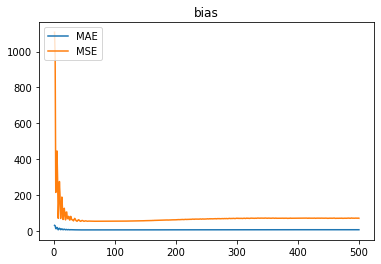

In [55]:
fig1 = plt.figure(1)
x=np.linspace(1,epo,epo)
plt.plot(x,test_error_MAE, label = 'MAE')
plt.plot(x,test_error_MSE, label ='MSE')
plt.legend(loc = 2)
plt.title('bias')

plt.show()

In [56]:
print('testing data MAE is ', np.min(test_error_MAE))
print('testing data MAE is ', np.min(test_error_MSE))

testing data MAE is  5.337720153276558
testing data MAE is  53.28231850709395


## Gradient descent (loss = MSE)

In [57]:
x1 = X1hat_train
x2 = X2hat_train
y = Yhat_train
xt1 = X1hat_test
xt2 = X2hat_test
yt = Yhat_test

In [58]:
def model (x1,x2,b0,b1,b2):
    y = b0 +  torch.matmul(x1,b1) + x2*b2
    return y

In [59]:
features1 = torch.from_numpy(x1)
features2 = torch.from_numpy(x2)
targets = torch.from_numpy(y)
x_test1 = torch.from_numpy(xt1)
x_test2 = torch.from_numpy(xt2)
y_test = torch.from_numpy(yt)


beta0 = torch.zeros(5112 , requires_grad = True)
beta1 = torch.zeros([3408,5112], requires_grad = True)
beta2 = torch.zeros(5112, requires_grad = True)

rate = 1e-3
optimizer = optim.Adam([beta0 , beta1 , beta2], lr=rate)

epo = 500
loss = nn.MSELoss()
train_error = np.zeros(epo)
test_error_MAE = np.zeros(epo)
test_error_MSE = np.zeros(epo)

for epoch in range (epo):
    yhats_train = model(features1.float() , features2.float(), beta0 , beta1 , beta2)
    train_loss = loss(targets.float() , yhats_train)
    train_error[epoch] = train_loss

    optimizer.zero_grad()
    train_loss.backward() 
    optimizer.step()    

    yhats_test = model(x_test1.float(), x_test2.float() , beta0, beta1 , beta2) 
    test_error_MAE[epoch] = torch.mean(torch.abs(yhats_test - y_test))
    test_error_MSE[epoch] = torch.mean((yhats_test - y_test)**2)

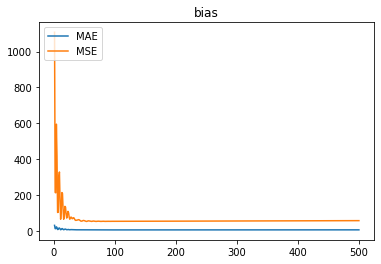

In [60]:
fig1 = plt.figure(1)
x=np.linspace(1,epo,epo)
plt.plot(x,test_error_MAE, label = 'MAE')
plt.plot(x,test_error_MSE, label ='MSE')
plt.legend(loc = 2)
plt.title('bias')

plt.show()

In [61]:
print('testing data MAE is ', np.min(test_error_MAE))
print('testing data MAE is ', np.min(test_error_MSE))

testing data MAE is  5.371151746278425
testing data MAE is  52.73877681784457


## Gradient descent (loss = Huber loss)

In [62]:
x1 = X1hat_train
x2 = X2hat_train
y = Yhat_train
xt1 = X1hat_test
xt2 = X2hat_test
yt = Yhat_test

In [63]:
def model (x1,x2,b0,b1,b2):
    y = b0 +  torch.matmul(x1,b1) + x2*b2
    return y

In [64]:
features1 = torch.from_numpy(x1)
features2 = torch.from_numpy(x2)
targets = torch.from_numpy(y)
x_test1 = torch.from_numpy(xt1)
x_test2 = torch.from_numpy(xt2)
y_test = torch.from_numpy(yt)


beta0 = torch.zeros(5112 , requires_grad = True)
beta1 = torch.zeros([3408,5112], requires_grad = True)
beta2 = torch.zeros(5112, requires_grad = True)

rate = 1e-3
optimizer = optim.Adam([beta0 , beta1 , beta2], lr=rate)

epo = 500
loss = nn.HuberLoss()
train_error = np.zeros(epo)
test_error_MAE = np.zeros(epo)
test_error_MSE = np.zeros(epo)

for epoch in range (epo):
    yhats_train = model(features1.float() , features2.float(), beta0 , beta1 , beta2)
    train_loss = loss(targets.float() , yhats_train)
    train_error[epoch] = train_loss

    optimizer.zero_grad()
    train_loss.backward() 
    optimizer.step()    

    yhats_test = model(x_test1.float(), x_test2.float() , beta0, beta1 , beta2) 
    test_error_MAE[epoch] = torch.mean(torch.abs(yhats_test - y_test))
    test_error_MSE[epoch] = torch.mean((yhats_test - y_test)**2)

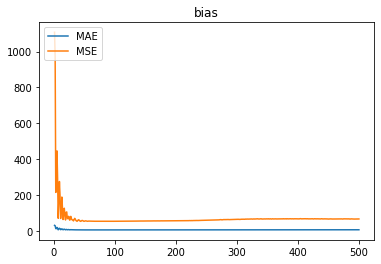

In [65]:
fig1 = plt.figure(1)
x=np.linspace(1,epo,epo)
plt.plot(x,test_error_MAE, label = 'MAE')
plt.plot(x,test_error_MSE, label ='MSE')
plt.legend(loc = 2)
plt.title('bias')

plt.show()

In [66]:
print('testing data MAE is ', np.min(test_error_MAE))
print('testing data MAE is ', np.min(test_error_MSE))

testing data MAE is  5.332192813359541
testing data MAE is  53.14791749407828


# Function on Function Model

## 公式解（PCA + Linear regression）

In [7]:
x = Xhat_train
y = Yhat_train
xt = Xhat_test
yt = Yhat_test

In [8]:
xper = np.zeros(5)
xper[0] = 0.85
xper[1] = 0.9
xper[2] = 0.95
xper[3] = 0.99
xper[4] = 0.995
yper = xper
test_error_MAE = 100*np.ones(25)
test_error_MSE = 100*np.ones(25)
MAE_index=[]
MSE_index=[]

In [9]:
for z in range (0,5):
    for w in range (0,5):
        pca_x = PCA(n_components=xper[z])
        pca_x.fit(x)
        x_pca=pca_x.transform(x)
        
        pca_y = PCA(n_components=yper[w])
        pca_y.fit(y)
        y_pca=pca_y.transform(y)
        
        model = LinearRegression()
        model.fit(x_pca, y_pca)

        xt_pca = pca_x.transform(xt)
        fit_x = model.predict(xt_pca)
        fit = pca_y.inverse_transform(fit_x)
        
        mae = np.mean(abs(fit-yt))
        mse = np.mean((fit-yt)**2)
        test_error_MAE[z*5+w] = mae
        test_error_MSE[z*5+w] = mse
        MAE_index.append((xper[z], yper[w], mae))
        MSE_index.append((xper[z], yper[w], mse))

In [10]:
f1 = np.argmin(test_error_MAE)
f2 = np.argmin(test_error_MSE)
print('test data on x = ', 100*MAE_index[f1][0], '% Y = ', 100*MAE_index[f1][1], '% have the min MAE error :', min(test_error_MAE))
print(MAE_index[f1])
print('test data on x = ', 100*MSE_index[f2][0], '% Y = ', 100*MSE_index[f2][1], '% have the min MSE error :', min(test_error_MSE))
print(MSE_index[f2])

test data on x =  85.0 % Y =  85.0 % have the min MAE error : 5.228143308960006
(0.85, 0.85, 5.228143308960006)
test data on x =  85.0 % Y =  85.0 % have the min MSE error : 46.31783755107955
(0.85, 0.85, 46.31783755107955)


# PLS Model

In [11]:
x = Xhat_train
y = Yhat_train
xt = Xhat_test
yt = Yhat_test

In [12]:
test_error_MAE = 100*np.ones(50)
test_error_MSE = 100*np.ones(50)
for n in range (1,51):
    model = PLSRegression(n_components=n,max_iter=1000)
    model.fit(x, y)

    xf=Xhat_test
    xfit=model.predict(xf)
    
    after_MAE=np.nanmean(abs(xfit-yt))
    after_MSE=np.nanmean((xfit-yt)**2)
    
    test_error_MAE[n-1] = after_MAE
    test_error_MSE[n-1] = after_MSE

In [13]:
print('test data on n = ', np.argmin(test_error_MAE)+1, 'have the min MAE error : ', min(test_error_MAE))
print('test data on n = ', np.argmin(test_error_MSE)+1, 'have the min MSE error : ', min(test_error_MSE))

test data on n =  10 have the min MAE error :  5.162559284501209
test data on n =  10 have the min MSE error :  45.33898041904606


# SIR Model

In [28]:
x = Xhat_train
y = Yhat_train
xt = Xhat_test
yt = Yhat_test

In [29]:
# xper = np.zeros(5)
# xper[0] = 0.85
# xper[1] = 0.90
# xper[2] = 0.95
# xper[3] = 0.99
# xper[4] = 0.995
# yper = np.zeros(3)
# yper[0] = 0.95
# yper[1] = 0.99
# yper[2] = 0.995
# slices = np.zeros(5)
# slices[0] = 10
# slices[1] = 20
# slices[2] = 30
# slices[3] = 40
# slices[4] = 50
# test_error_MAE = 100*np.ones(15)
# test_error_MSE = 100*np.ones(15)
# index_MAE = []
# index_MSE = []

In [30]:
#x : 70%~85% (85.9%剛好=61=n_targets)
xper = np.zeros(16)
for i in range (0,16):
    xper[i] = 0.01*(i+70)
    
#y : 80%~88% (88.4%剛好=61=n_targets)
yper = np.zeros(9)
for i in range (0,9):
    yper[i] = 0.01*(i+80)
#slices : 10, 20, 30, 40, 50
slices = np.zeros(5)
for i in range (0,5):
    slices[i] = 10*(i+1)
#存結果用
test_error_MAE = 100*np.ones(16*9)
test_error_MSE = 100*np.ones(16*9)
index_MAE = []
index_MSE = []

In [31]:
for q in range (0,16):
    for r in range(0,9):
        pca_x = PCA(n_components=xper[q])
        pca_x.fit(x)
        x_pca=pca_x.transform(x)
        a = x_pca.shape[1]
        if a > 61:
            continue
        pca_y = PCA(n_components=yper[r])
        pca_y.fit(y)
        y_pca=pca_y.transform(y)
        b = y_pca.shape[1]
        if b > 61:
            continue
        pca_xt = PCA(n_components=a)
        pca_xt.fit(xt)
        xt_pca=pca_xt.transform(xt)
#         pca_yt = PCA(n_components=b)
#         pca_yt.fit(yt)
#         yt_pca=pca_y.transform(yt)

        xt_svr = np.zeros([5,61,b])
        #5是因為有5種n_slices
        for j in range (0,5):
            for i in range (0,b):
                sir_x = SlicedInverseRegression(n_slices=slices[j])
                sir_x.fit(x_pca, y_pca[:,i])
                x_sir = sir_x.transform(x_pca)
                   
                svr = SVR()
                svr.fit(x_sir, y_pca[:,i])
                
                xt_sir = sir_x.transform(xt_pca) 
                xt_svr[j][:,i]=svr.predict(xt_sir)
        error1 = np.zeros(5)
        error2 = np.zeros(5)
        for i in range (0,5):
            yt_inv = pca_y.inverse_transform(xt_svr[i])
            error1[i] = np.mean(abs(yt_inv-yt))
            error2[i] = np.mean((yt_inv-yt)**2)

        n1 = 10*(np.argmin(error1)+1)
        n2 = 10*(np.argmin(error2)+1)
        min1 = min(error1)
        min2 = min(error2)
        index_MAE.append((xper[q], yper[r], n1, min1))    
        index_MSE.append((xper[q], yper[r], n2, min2)) 
        test_error_MAE[9*q+r] = min1
        test_error_MSE[9*q+r] = min2

In [32]:
f1 = np.argmin(test_error_MAE)
f2 = np.argmin(test_error_MSE)
print('test data on n_slices = ', index_MAE[f1][2], ', x = ', index_MAE[f1][0], '% , y = ', index_MAE[f1][1], '% have the min MAE error :', min(test_error_MAE))
print(index_MAE[f1])
print('test data on n_slices = ', index_MSE[f2][2], ', x = ', index_MSE[f2][0], '% , y = ', index_MSE[f2][1], '% have the min MSE error :', min(test_error_MSE))
print(index_MSE[f2])

test data on n_slices =  30 , x =  0.8200000000000001 % , y =  0.8 % have the min MAE error : 5.682487449627488
(0.8200000000000001, 0.8, 30, 5.682487449627488)
test data on n_slices =  10 , x =  0.72 % , y =  0.86 % have the min MSE error : 54.67626113193391
(0.72, 0.86, 10, 54.67626113193391)


# CNN Model

In [8]:
Xhat_train_n = np.zeros([71,540,120])
Yhat_train_n = np.zeros([71,540,72])
Xhat_test_n = np.zeros([71,61,120])
Yhat_test_n = np.zeros([71,61,72])
for i in range (0,71):
    for j in range (0,540):
        for k in range (0,48):
            Xhat_train_n[i][j][k] = Xhat_train[j][48*i+k]
        for k in range (0,72):
            Xhat_train_n[i][j][k+48] = Xhat_train[j][1704+(72*i)+k]
            Yhat_train_n[i][j][k] = Yhat_train[j][(72*i)+k]
    for j in range (0,61):
        for k in range (0,48):
            Xhat_test_n[i][j][k] = Xhat_test[j][48*i+k]
        for k in range (0,72):
            Xhat_test_n[i][j][k+48] = Xhat_test[j][1704+(72*i)+k]
            Yhat_test_n[i][j][k] = Yhat_test[j][(72*i)+k]
print('Xhat_train')
print(np.shape(Xhat_train_n))
print('Yhat_train')
print(np.shape(Yhat_train_n))
print('Xhat_test')
print(np.shape(Xhat_test_n))
print('Yhat_test')
print(np.shape(Yhat_test_n))
Xhat_val=Xhat_test_n
Yhat_val=Yhat_test_n
print('Xhat_val')
print(np.shape(Xhat_val))
print('Yhat_val')
print(np.shape(Yhat_val))

Xhat_train
(71, 540, 120)
Yhat_train
(71, 540, 72)
Xhat_test
(71, 61, 120)
Yhat_test
(71, 61, 72)
Xhat_val
(71, 61, 120)
Yhat_val
(71, 61, 72)


## loss = MAE

In [9]:
class CNN(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Conv1d(1 , 32 , 2)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Conv1d(32 , 32 , 2)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Conv1d(32, 32 , 2)
        self.act3 = nn.ReLU()
        self.layer4 = nn.Conv1d(32 , 32 , 2)
        self.act4 = nn.ReLU()
        self.layer5 = nn.Conv1d(32 , 32 , 2)
        self.act5 = nn.ReLU()
        self.fl = nn.Flatten()
        self.fc1 = nn.Linear(115*32,264)
        self.fc2 = nn.Linear(264,72)
    
    def forward(self, x): 
        ouput = torch.unsqueeze(x,1)
        ouput = self.act1(self.layer1(ouput))
        ouput = self.act2(self.layer2(ouput))
        ouput = self.act3(self.layer3(ouput))
        ouput = self.act4(self.layer4(ouput))
        ouput = self.act5(self.layer5(ouput))
        ouput = self.fl(ouput)
        ouput = self.fc1(ouput)
        ouput = self.fc2(ouput)
        return ouput

    def configure_optimizers(self): 
        return optim.Adam(self.parameters(), lr=1e-4) 

    def prepare_data(self): 
        self.train_set = Data.TensorDataset(x_train , y_train) 
        self.test_set = Data.TensorDataset(x_test, y_test)
        self.val_set = Data.TensorDataset(x_val, y_val)

    def train_dataloader(self):
        return Data.DataLoader(dataset=self.train_set , batch_size=540 , shuffle=True)

    def test_dataloader(self):
        return Data.DataLoader(dataset=self.test_set , batch_size=61 , shuffle=False)

    def val_dataloader(self):
        return Data.DataLoader(dataset=self.val_set , batch_size=61 , shuffle=False)

    def training_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.L1Loss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

    def test_step(self, batch, batch_idx):
        x, y = batch 
        output  = self.forward(x)
        loss = nn.L1Loss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch 
        output  = self.forward(x)
        loss = nn.L1Loss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

In [ ]:
for i in range (0,71):
    x_train = torch.from_numpy(Xhat_train_n[i]).float()
    y_train = torch.from_numpy(Yhat_train_n[i]).float()
    x_test = torch.from_numpy(Xhat_test_n[i]).float()
    y_test = torch.from_numpy(Yhat_test_n[i]).float()
    x_val = torch.from_numpy(Xhat_val[i]).float()
    y_val = torch.from_numpy(Yhat_val[i]).float()
    
    logger = CSVLogger("CNN Model", name="CNN_120hr_MAE")
    model = CNN() 
    trainer = pl.Trainer(max_epochs=500 , gpus=1 , logger=logger)
    trainer.fit(model)
    trainer.test(model)

In [11]:
test_error_MAE = np.zeros(71)
test_error_MSE = np.zeros(71)
for i in range (0,71):
    df = pd.read_csv("/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/CNN Model/CNN_120hr_MAE/version_"+str(i)+"/metrics.csv")
    s1 = np.array(df['MAE'].fillna(100))
    s2 = np.array(df['MSE'].fillna(100))
    test_error_MAE[i] = np.min(s1)
    test_error_MSE[i] = np.min(s2)

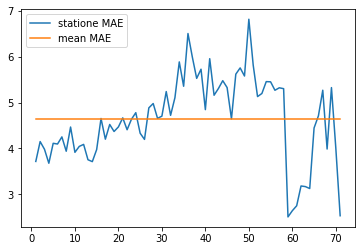

In [12]:
m = np.nanmean(test_error_MAE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MAE, label = 'statione MAE')
plt.plot(x,m, label = 'mean MAE')
plt.legend(loc = 2)

plt.show()

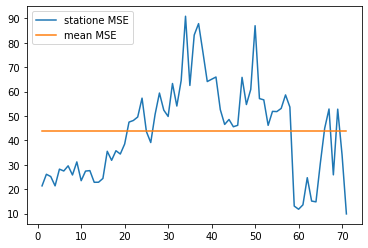

In [13]:
m = np.nanmean(test_error_MSE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MSE, label = 'statione MSE')
plt.plot(x,m, label = 'mean MSE')
plt.legend(loc = 2)

plt.show()

In [14]:
print('testing data MAE is ', np.nanmean(test_error_MAE))
print('testing data MAE is ', np.nanmean(test_error_MSE))

testing data MAE is  4.6394846943062795
testing data MAE is  43.89225508461536


## loss = MSE

In [15]:
class CNN(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Conv1d(1 , 32 , 2)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Conv1d(32 , 32 , 2)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Conv1d(32, 32 , 2)
        self.act3 = nn.ReLU()
        self.layer4 = nn.Conv1d(32 , 32 , 2)
        self.act4 = nn.ReLU()
        self.layer5 = nn.Conv1d(32 , 32 , 2)
        self.act5 = nn.ReLU()
        self.fl = nn.Flatten()
        self.fc1 = nn.Linear(115*32,264)
        self.fc2 = nn.Linear(264,72)
    
    def forward(self, x): 
        ouput = torch.unsqueeze(x,1)
        ouput = self.act1(self.layer1(ouput))
        ouput = self.act2(self.layer2(ouput))
        ouput = self.act3(self.layer3(ouput))
        ouput = self.act4(self.layer4(ouput))
        ouput = self.act5(self.layer5(ouput))
        ouput = self.fl(ouput)
        ouput = self.fc1(ouput)
        ouput = self.fc2(ouput)
        return ouput

    def configure_optimizers(self): 
        return optim.Adam(self.parameters(), lr=1e-4) 

    def prepare_data(self): 
        self.train_set = Data.TensorDataset(x_train , y_train) 
        self.test_set = Data.TensorDataset(x_test, y_test)
        self.val_set = Data.TensorDataset(x_val, y_val)

    def train_dataloader(self):
        return Data.DataLoader(dataset=self.train_set , batch_size=540 , shuffle=True)

    def test_dataloader(self):
        return Data.DataLoader(dataset=self.test_set , batch_size=61 , shuffle=False)

    def val_dataloader(self):
        return Data.DataLoader(dataset=self.val_set , batch_size=61 , shuffle=False)

    def training_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.MSELoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

    def test_step(self, batch, batch_idx):
        x, y = batch 
        output  = self.forward(x)
        loss = nn.MSELoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch 
        output  = self.forward(x)
        loss = nn.MSELoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

In [ ]:
for i in range (0,71):
    x_train = torch.from_numpy(Xhat_train_n[i]).float()
    y_train = torch.from_numpy(Yhat_train_n[i]).float()
    x_test = torch.from_numpy(Xhat_test_n[i]).float()
    y_test = torch.from_numpy(Yhat_test_n[i]).float()
    x_val = torch.from_numpy(Xhat_val[i]).float()
    y_val = torch.from_numpy(Yhat_val[i]).float()
    
    logger = CSVLogger("CNN Model", name="CNN_120hr_MSE")
    model = CNN() 
    trainer = pl.Trainer(max_epochs=500 , gpus=1 , logger=logger)
    trainer.fit(model)
    trainer.test(model)

In [17]:
test_error_MAE = np.zeros(71)
test_error_MSE = np.zeros(71)
for i in range (0,71):
    df = pd.read_csv("/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/CNN Model/CNN_120hr_MSE/version_"+str(i)+"/metrics.csv")
    s1 = np.array(df['MAE'].fillna(100))
    s2 = np.array(df['MSE'].fillna(100))
    test_error_MAE[i] = np.min(s1)
    test_error_MSE[i] = np.min(s2)

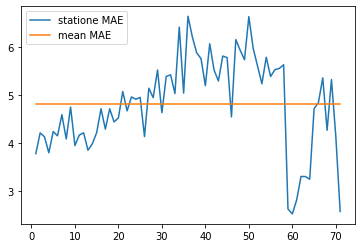

In [18]:
m = np.nanmean(test_error_MAE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MAE, label = 'statione MAE')
plt.plot(x,m, label = 'mean MAE')
plt.legend(loc = 2)

plt.show()

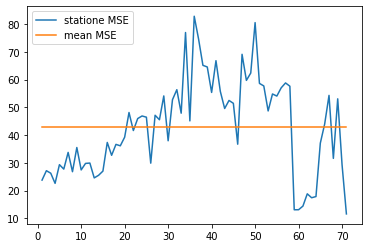

In [19]:
m = np.nanmean(test_error_MSE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MSE, label = 'statione MSE')
plt.plot(x,m, label = 'mean MSE')
plt.legend(loc = 2)

plt.show()

In [20]:
print('testing data MAE is ', np.nanmean(test_error_MAE))
print('testing data MAE is ', np.nanmean(test_error_MSE))

testing data MAE is  4.81722925078701
testing data MAE is  42.99165223349988


## loss = Huber loss

In [21]:
class CNN(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Conv1d(1 , 32 , 2)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Conv1d(32 , 32 , 2)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Conv1d(32, 32 , 2)
        self.act3 = nn.ReLU()
        self.layer4 = nn.Conv1d(32 , 32 , 2)
        self.act4 = nn.ReLU()
        self.layer5 = nn.Conv1d(32 , 32 , 2)
        self.act5 = nn.ReLU()
        self.fl = nn.Flatten()
        self.fc1 = nn.Linear(115*32,264)
        self.fc2 = nn.Linear(264,72)
    
    def forward(self, x): 
        ouput = torch.unsqueeze(x,1)
        ouput = self.act1(self.layer1(ouput))
        ouput = self.act2(self.layer2(ouput))
        ouput = self.act3(self.layer3(ouput))
        ouput = self.act4(self.layer4(ouput))
        ouput = self.act5(self.layer5(ouput))
        ouput = self.fl(ouput)
        ouput = self.fc1(ouput)
        ouput = self.fc2(ouput)
        return ouput

    def configure_optimizers(self): 
        return optim.Adam(self.parameters(), lr=1e-4) 

    def prepare_data(self): 
        self.train_set = Data.TensorDataset(x_train , y_train) 
        self.test_set = Data.TensorDataset(x_test, y_test)
        self.val_set = Data.TensorDataset(x_val, y_val)

    def train_dataloader(self):
        return Data.DataLoader(dataset=self.train_set , batch_size=540 , shuffle=True)

    def test_dataloader(self):
        return Data.DataLoader(dataset=self.test_set , batch_size=61 , shuffle=False)

    def val_dataloader(self):
        return Data.DataLoader(dataset=self.val_set , batch_size=61 , shuffle=False)

    def training_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.HuberLoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

    def test_step(self, batch, batch_idx):
        x, y = batch 
        output  = self.forward(x)
        loss = nn.HuberLoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch 
        output  = self.forward(x)
        loss = nn.HuberLoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

In [ ]:
for i in range (0,71):
    x_train = torch.from_numpy(Xhat_train_n[i]).float()
    y_train = torch.from_numpy(Yhat_train_n[i]).float()
    x_test = torch.from_numpy(Xhat_test_n[i]).float()
    y_test = torch.from_numpy(Yhat_test_n[i]).float()
    x_val = torch.from_numpy(Xhat_val[i]).float()
    y_val = torch.from_numpy(Yhat_val[i]).float()
    
    logger = CSVLogger("CNN Model", name="CNN_120hr_Huber")
    model = CNN() 
    trainer = pl.Trainer(max_epochs=500 , gpus=1 , logger=logger)
    trainer.fit(model)
    trainer.test(model)

In [23]:
test_error_MAE = np.zeros(71)
test_error_MSE = np.zeros(71)
for i in range (0,71):
    df = pd.read_csv("/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/CNN Model/CNN_120hr_Huber/version_"+str(i)+"/metrics.csv")
    s1 = np.array(df['MAE'].fillna(100))
    s2 = np.array(df['MSE'].fillna(100))
    test_error_MAE[i] = np.min(s1)
    test_error_MSE[i] = np.min(s2)

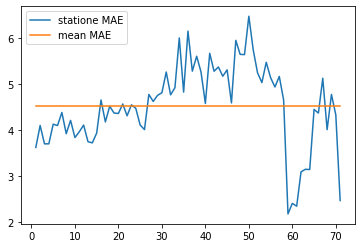

In [24]:
m = np.nanmean(test_error_MAE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MAE, label = 'statione MAE')
plt.plot(x,m, label = 'mean MAE')
plt.legend(loc = 2)

plt.show()

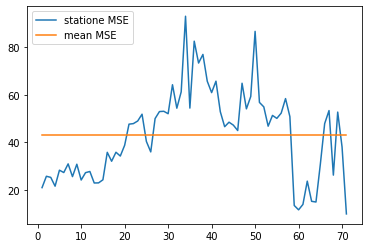

In [25]:
m = np.nanmean(test_error_MSE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MSE, label = 'statione MSE')
plt.plot(x,m, label = 'mean MSE')
plt.legend(loc = 2)

plt.show()

In [26]:
print('testing data MAE is ', np.nanmean(test_error_MAE))
print('testing data MAE is ', np.nanmean(test_error_MSE))

testing data MAE is  4.528438322980639
testing data MAE is  43.303271938377705


# Transformer Model

In [13]:
Xhat_train_n = np.zeros([71,540,120])
Yhat_train_n = np.zeros([71,540,72])
Xhat_test_n = np.zeros([71,61,120])
Yhat_test_n = np.zeros([71,61,72])
for i in range (0,71):
    for j in range (0,540):
        for k in range (0,48):
            Xhat_train_n[i][j][k] = Xhat_train[j][48*i+k]
        for k in range (0,72):
            Xhat_train_n[i][j][k+48] = Xhat_train[j][1704+(72*i)+k]
            Yhat_train_n[i][j][k] = Yhat_train[j][(72*i)+k]
    for j in range (0,61):
        for k in range (0,48):
            Xhat_test_n[i][j][k] = Xhat_test[j][48*i+k]
        for k in range (0,72):
            Xhat_test_n[i][j][k+48] = Xhat_test[j][1704+(72*i)+k]
            Yhat_test_n[i][j][k] = Yhat_test[j][(72*i)+k]
print('Xhat_train')
print(np.shape(Xhat_train_n))
print('Yhat_train')
print(np.shape(Yhat_train_n))
print('Xhat_test')
print(np.shape(Xhat_test_n))
print('Yhat_test')
print(np.shape(Yhat_test_n))
Xhat_val_n=Xhat_test_n
Yhat_val_n=Yhat_test_n
print('Xhat_val')
print(np.shape(Xhat_val_n))
print('Yhat_val')
print(np.shape(Yhat_val_n))

Xhat_train
(71, 540, 120)
Yhat_train
(71, 540, 72)
Xhat_test
(71, 61, 120)
Yhat_test
(71, 61, 72)
Xhat_val
(71, 61, 120)
Yhat_val
(71, 61, 72)


In [23]:
Xhat_train_n0 = np.zeros([71, 540, 192])
Xhat_val_n0 = np.zeros([71, 61, 192])
Xhat_test_n0 = np.zeros([71, 61, 192])
for k in range(0,71):
    for i in range (0,540):
        for j in range (0,120):
            Xhat_train_n0[k][i][j] = Xhat_train_n[k][i][j]
        for j in range (120,192):
            Xhat_train_n0[k][i][j] = Yhat_train_n[k][i][j-120]
for k in range(0,71):
    for i in range (0,61):
        for j in range (0,120):
            Xhat_val_n0[k][i][j] = Xhat_val_n[k][i][j]
        for j in range (120,192):
            Xhat_val_n0[k][i][j] = Yhat_val_n[k][i][j-120]
for k in range(0,71):
    for i in range (0,61):
        for j in range (0,120):
            Xhat_test_n0[k][i][j] = Xhat_test_n[k][i][j]
        for j in range (120,192):
            Xhat_test_n0[k][i][j] = Yhat_test_n[k][i][j-120]
print('Xhat_train')
print(np.shape(Xhat_train_n0))
print('Yhat_train')
print(np.shape(Yhat_train_n))
print('Xhat_test')
print(np.shape(Xhat_test_n0))
print('Yhat_test')
print(np.shape(Yhat_test_n))
print('Xhat_val')
print(np.shape(Xhat_val_n0))
print('Yhat_val')
print(np.shape(Yhat_val_n))

Xhat_train
(71, 540, 192)
Yhat_train
(71, 540, 72)
Xhat_test
(71, 61, 192)
Yhat_test
(71, 61, 72)
Xhat_val
(71, 61, 192)
Yhat_val
(71, 61, 72)


## loss = MAE

In [24]:
class Transformer(pl.LightningModule): 
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(120,72)
        self.layer2 = nn.Transformer(d_model=72, nhead=72)
    
    def forward(self, x):
        ouput = self.layer1(x[:,:120])
        ouput = self.layer2(ouput, x[:,120:]) 
        return ouput

    def configure_optimizers(self): 
        return optim.Adam(self.parameters(), lr=1e-2) 

    def prepare_data(self): 
        self.train_set = Data.TensorDataset(x_train , y_train) 
        self.test_set = Data.TensorDataset(x_test, y_test)
        self.val_set = Data.TensorDataset(x_val, y_val)

    def train_dataloader(self):
        return Data.DataLoader(dataset=self.train_set , batch_size=540 , shuffle=True)

    def test_dataloader(self):
        return Data.DataLoader(dataset=self.test_set , batch_size=61 , shuffle=False)

    def val_dataloader(self):
        return Data.DataLoader(dataset=self.val_set , batch_size=61 , shuffle=False)

    def training_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.L1Loss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

    def test_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.L1Loss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}


    def validation_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.L1Loss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

In [ ]:
for i in range (0,71):
    x_train = torch.from_numpy(Xhat_train_n0[i]).float()
    y_train = torch.from_numpy(Yhat_train_n[i]).float()
    x_test = torch.from_numpy(Xhat_test_n0[i]).float()
    y_test = torch.from_numpy(Yhat_test_n[i]).float()
    x_val = torch.from_numpy(Xhat_val_n0[i]).float()
    y_val = torch.from_numpy(Yhat_val_n[i]).float()
    
    logger = CSVLogger("Transformer Model", name="Transformer_120hr_MAE")
    model = Transformer() 
    trainer = pl.Trainer(max_epochs=1500 , gpus=1 , logger=logger)
    trainer.fit(model)
    trainer.test(model)

In [26]:
test_error_MAE = np.zeros(71)
test_error_MSE = np.zeros(71)
for i in range (0,71):
    df = pd.read_csv("/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/Transformer Model/Transformer_120hr_MAE/version_"+str(i)+"/metrics.csv")
    s1 = np.array(df['MAE'].fillna(100))
    s2 = np.array(df['MSE'].fillna(100))
    test_error_MAE[i] = np.min(s1)
    test_error_MSE[i] = np.min(s2)

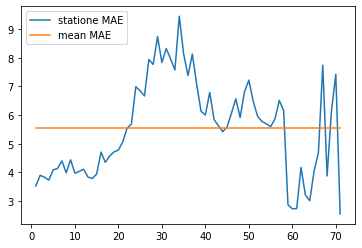

In [27]:
m = np.nanmean(test_error_MAE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MAE, label = 'statione MAE')
plt.plot(x,m, label = 'mean MAE')
plt.legend(loc = 2)

plt.show()

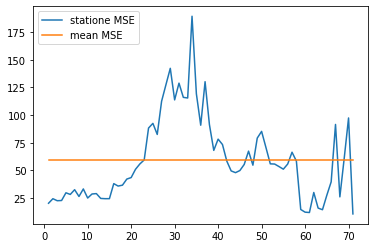

In [28]:
m = np.nanmean(test_error_MSE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MSE, label = 'statione MSE')
plt.plot(x,m, label = 'mean MSE')
plt.legend(loc = 2)

plt.show()

In [29]:
print('testing data MAE is ', np.nanmean(test_error_MAE))
print('testing data MAE is ', np.nanmean(test_error_MSE))

testing data MAE is  5.540480230895566
testing data MAE is  58.95546437653018


## loss = mse

In [ ]:
class Transformer(pl.LightningModule): 
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(120,72)
        self.layer2 = nn.Transformer(d_model=72, nhead=72)
    
    def forward(self, x):
        ouput = self.layer1(x[:,:120])
        ouput = self.layer2(ouput, x[:,120:]) 
        return ouput

    def configure_optimizers(self): 
        return optim.Adam(self.parameters(), lr=1e-2) 

    def prepare_data(self): 
        self.train_set = Data.TensorDataset(x_train , y_train) 
        self.test_set = Data.TensorDataset(x_test, y_test)
        self.val_set = Data.TensorDataset(x_val, y_val)

    def train_dataloader(self):
        return Data.DataLoader(dataset=self.train_set , batch_size=540 , shuffle=True)

    def test_dataloader(self):
        return Data.DataLoader(dataset=self.test_set , batch_size=61 , shuffle=False)

    def val_dataloader(self):
        return Data.DataLoader(dataset=self.val_set , batch_size=61 , shuffle=False)

    def training_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.MSELoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

    def test_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.MSELoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}


    def validation_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.MSELoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

In [ ]:
for i in range (0,71):
    x_train = torch.from_numpy(Xhat_train_n0[i]).float()
    y_train = torch.from_numpy(Yhat_train_n[i]).float()
    x_test = torch.from_numpy(Xhat_test_n0[i]).float()
    y_test = torch.from_numpy(Yhat_test_n[i]).float()
    x_val = torch.from_numpy(Xhat_val_n0[i]).float()
    y_val = torch.from_numpy(Yhat_val_n[i]).float()
    
    logger = CSVLogger("Transformer Model", name="Transformer_120hr_MSE")
    model = Transformer() 
    trainer = pl.Trainer(max_epochs=1500 , gpus=1 , logger=logger)
    trainer.fit(model)
    trainer.test(model)

In [ ]:
test_error_MAE = np.zeros(71)
test_error_MSE = np.zeros(71)
for i in range (0,71):
    df = pd.read_csv("/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/Transformer Model/Transformer_120hr_MSE/version_"+str(i)+"/metrics.csv")
    s1 = np.array(df['MAE'].fillna(100))
    s2 = np.array(df['MSE'].fillna(100))
    test_error_MAE[i] = np.min(s1)
    test_error_MSE[i] = np.min(s2)

In [ ]:
m = np.nanmean(test_error_MAE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MAE, label = 'statione MAE')
plt.plot(x,m, label = 'mean MAE')
plt.legend(loc = 2)

plt.show()

In [ ]:
m = np.nanmean(test_error_MSE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MSE, label = 'statione MSE')
plt.plot(x,m, label = 'mean MSE')
plt.legend(loc = 2)

plt.show()

In [ ]:
print('testing data MAE is ', np.nanmean(test_error_MAE))
print('testing data MAE is ', np.nanmean(test_error_MSE))

## loss = Huber loss

In [ ]:
class Transformer(pl.LightningModule): 
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(120,72)
        self.layer2 = nn.Transformer(d_model=72, nhead=72)
    
    def forward(self, x):
        ouput = self.layer1(x[:,:120])
        ouput = self.layer2(ouput, x[:,120:]) 
        return ouput

    def configure_optimizers(self): 
        return optim.Adam(self.parameters(), lr=1e-2) 

    def prepare_data(self): 
        self.train_set = Data.TensorDataset(x_train , y_train) 
        self.test_set = Data.TensorDataset(x_test, y_test)
        self.val_set = Data.TensorDataset(x_val, y_val)

    def train_dataloader(self):
        return Data.DataLoader(dataset=self.train_set , batch_size=540 , shuffle=True)

    def test_dataloader(self):
        return Data.DataLoader(dataset=self.test_set , batch_size=61 , shuffle=False)

    def val_dataloader(self):
        return Data.DataLoader(dataset=self.val_set , batch_size=61 , shuffle=False)

    def training_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.HuberLoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

    def test_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.HuberLoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}


    def validation_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.HuberLoss(reduction='mean')(output, y)
        mae = nn.L1Loss(reduction='mean')(output, y)
        mse = nn.MSELoss(reduction='mean')(output, y)
        self.log("train_loss", loss)
        self.log("MAE", mae)
        self.log("MSE", mse)
        return {'loss' : loss}

In [ ]:
for i in range (0,71):
    x_train = torch.from_numpy(Xhat_train_n0[i]).float()
    y_train = torch.from_numpy(Yhat_train_n[i]).float()
    x_test = torch.from_numpy(Xhat_test_n0[i]).float()
    y_test = torch.from_numpy(Yhat_test_n[i]).float()
    x_val = torch.from_numpy(Xhat_val_n0[i]).float()
    y_val = torch.from_numpy(Yhat_val_n[i]).float()
    
    logger = CSVLogger("Transformer Model", name="Transformer_120hr_Huber")
    model = Transformer() 
    trainer = pl.Trainer(max_epochs=1500 , gpus=1 , logger=logger)
    trainer.fit(model)
    trainer.test(model)

In [ ]:
test_error_MAE = np.zeros(71)
test_error_MSE = np.zeros(71)
for i in range (0,71):
    df = pd.read_csv("/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/Transformer Model/Transformer_120hr_Huber/version_"+str(i)+"/metrics.csv")
    s1 = np.array(df['MAE'].fillna(100))
    s2 = np.array(df['MSE'].fillna(100))
    test_error_MAE[i] = np.min(s1)
    test_error_MSE[i] = np.min(s2)

In [ ]:
m = np.nanmean(test_error_MAE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MAE, label = 'statione MAE')
plt.plot(x,m, label = 'mean MAE')
plt.legend(loc = 2)

plt.show()

In [ ]:
m = np.nanmean(test_error_MSE)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,test_error_MSE, label = 'statione MSE')
plt.plot(x,m, label = 'mean MSE')
plt.legend(loc = 2)

plt.show()

In [ ]:
print('testing data MAE is ', np.nanmean(test_error_MAE))
print('testing data MAE is ', np.nanmean(test_error_MSE))